# Пайплайн для выделения лучших кропов по текстовому запросу ViLD -> Clip -> Annoy

Все расчеты ниже получены по valid выборке датасета LVIS

* Применяем модель ViLD MaskRCNN к датасету, получаем кропы для картинок
* Применяем модель clip к каждому кропу, получаем эмбеддинги кропов
* Применяем модель clip к описанию категорий датасета LVIS, получаем эмбеддинги категорий
* Строим индекс annoy по эмбеддингам кропов для поиска ближайших соседей из кропов к каждой категории датасета
* Проводим анализ метрик

In [16]:
import tensorflow.compat.v1 as tf

tf.__version__

'2.7.1'

In [1]:
from assh_utils import get_iou, load_json, nms

In [2]:
import os

root = "/home/jupyter/mnt/s3/asciishell-fsod/LVIS/"
js = load_json("/home/jupyter/mnt/s3/asciishell-fsod/LVIS/lvis_v1_val.json.zip")
images = [root + x["coco_url"].replace("http://images.cocodataset.org/", "") for x in js["images"]]
assert all([os.path.exists(x) for x in images[:100]])

In [3]:
import itertools
import math
import os
import pickle

import clip
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
from annoy import AnnoyIndex
from sklearn.cluster import KMeans
from sklearn.metrics import average_precision_score
from tqdm.cli import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


## Применяем модель ViLD MaskRCNN с NMS
Сохраняем датафрейм с картинками и соответствующими кропами.

In [6]:
saved_model_dir = "/home/jupyter/mnt/s3/asciishell-fsod/image_path_v2"
session = tf.Session(graph=tf.Graph())
_ = tf.saved_model.loader.load(session, ["serve"], saved_model_dir)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from /home/jupyter/mnt/s3/asciishell-fsod/image_path_v2/variables/variables


/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:872: UserWarning: The following variables cannot be serialized: session
  warnings.warn(message)


In [7]:
from collections import defaultdict

nms_threshold = 0.6
min_rpn_score_thresh = 0.9
min_box_area = 220
max_boxes_to_draw = 30

results = defaultdict(list)
for name in tqdm(images):
    roi_boxes, roi_scores, detection_boxes, image_info = session.run(
        ["RoiBoxes:0", "RoiScores:0", "2ndStageBoxes:0", "ImageInfo:0"],
        feed_dict={
            "Placeholder:0": [
                name,
            ]
        },
    )

    roi_boxes = np.squeeze(roi_boxes, axis=0)  # squeeze
    roi_scores = np.squeeze(roi_scores, axis=0)
    detection_boxes = np.squeeze(detection_boxes, axis=(0, 2))
    image_info = np.squeeze(image_info, axis=0)  # obtain image info
    image_scale = np.tile(image_info[2:3, :], (1, 2))

    rescaled_detection_boxes = detection_boxes / image_scale  # rescale
    # Apply non-maximum suppression to detected boxes with nms threshold.
    nmsed_indices = nms(detection_boxes, roi_scores, thresh=nms_threshold)

    # Compute RPN box size.
    box_sizes = (rescaled_detection_boxes[:, 2] - rescaled_detection_boxes[:, 0]) * (
        rescaled_detection_boxes[:, 3] - rescaled_detection_boxes[:, 1]
    )

    # Filter out invalid rois (nmsed rois)
    valid_indices = np.where(
        np.logical_and(
            np.isin(np.arange(len(roi_scores), dtype=np.int), nmsed_indices),
            np.logical_and(
                np.logical_not(np.all(roi_boxes == 0.0, axis=-1)),
                np.logical_and(roi_scores >= min_rpn_score_thresh, box_sizes > min_box_area),
            ),
        )
    )[0]

    detection_roi_scores = roi_scores[valid_indices][:max_boxes_to_draw, ...]
    rescaled_detection_boxes = rescaled_detection_boxes[valid_indices][:max_boxes_to_draw, ...]
    ymin, xmin, ymax, xmax = np.split(rescaled_detection_boxes, 4, axis=-1)

    results["image"].extend([name] * len(xmin))
    results["xmin"].extend(xmin.reshape(1, -1)[0])
    results["ymin"].extend(ymin.reshape(1, -1)[0])
    results["xmax"].extend(xmax.reshape(1, -1)[0])
    results["ymax"].extend(ymax.reshape(1, -1)[0])
    results["roi_scores"].extend(detection_roi_scores)

results = pd.DataFrame(results)
results.to_pickle(f"/home/jupyter/mnt/s3/asciishell-fsod/RunMaskRCNN/valid.pkl.zip")

100%|██████████| 19809/19809 [1:14:22<00:00,  4.44it/s]
/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:872: UserWarning: The following variables cannot be serialized: session
  warnings.warn(message)


In [8]:
results.head()

,image,xmin,ymin,xmax,ymax,roi_scores
0,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/val2...,293.381561,81.120750,331.104492,131.361664,0.999746
1,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/val2...,208.240906,26.461271,238.645737,84.545235,0.999742
2,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/val2...,317.082184,115.037201,365.056030,151.289627,0.999477
3,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/val2...,321.055481,46.822239,337.211456,77.540009,0.999447
4,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/val2...,337.668274,46.672073,356.634399,79.231155,0.999442


Округляем границы bbox. Удаяем слишком маленькие кропы и дубликаты. Сохраняем отсортированный и сокращенный датафрейм с картинками и кропами.

In [10]:
dfs = pd.read_pickle("/home/jupyter/mnt/s3/asciishell-fsod/RunMaskRCNN/valid.pkl.zip")
dfs[["xmin", "ymin", "xmax", "ymax"]] = dfs[["xmin", "ymin", "xmax", "ymax"]].round().astype(np.int32).values
dfs = dfs[((dfs["xmin"] - dfs["xmax"]).abs() > 5) & ((dfs["ymin"] - dfs["ymax"]).abs() > 5)]
dfs = (
    dfs.sort_values(["image"])
    .drop_duplicates(["xmin", "ymin", "xmax", "ymax", "image"], keep="first")
    .sort_values(["image", "roi_scores", "xmin", "ymin", "xmax", "ymax"])
    .reset_index(drop=True)
)
dfs.to_pickle("/home/jupyter/mnt/s3/asciishell-fsod/RunMaskRCNN/valid.sorted.pkl.zip")
dfs

,image,xmin,ymin,xmax,ymax,roi_scores
0,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...,144,126,181,174,0.976964
1,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...,155,92,197,156,0.977112
2,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...,154,90,240,210,0.984891
3,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...,220,209,258,242,0.987218
4,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...,200,191,239,224,0.990206
...,...,...,...,...,...,...
422958,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/val2...,605,127,639,215,0.999944
422959,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/val2...,477,151,560,224,0.999953
422960,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/val2...,74,158,175,212,0.999956
422961,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/val2...,61,215,127,342,0.999965


## Применяем модель clip к каждому кропу

Сохраняем полученные эмбеддинги для каждого кропа и датафрейм с картинками и кропами в соответствующем порядке.

In [11]:
clip_model, clip_preprocess = clip.load("/home/jupyter/mnt/s3/asciishell-fsod/models/ViT-B-32.pt", device)

In [12]:
embeddings = []
images = []
for index, row in tqdm(dfs.groupby("image")):
    img = PIL.Image.open(index)
    for _, row2 in row.iterrows():
        img_crop = img.crop(box=row2[["xmin", "ymin", "xmax", "ymax"]].values)
        image_input = clip_preprocess(img_crop).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = clip_model.encode_image(image_input)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        embeddings.append(image_features[0].cpu().numpy())
        images.append(row2.to_dict())
embeddings = np.stack(embeddings)
images = pd.DataFrame(images)
np.save("/home/jupyter/mnt/s3/asciishell-fsod/RunMaskRCNN/valid_emb.npy", embeddings)
images.to_pickle("/home/jupyter/mnt/s3/asciishell-fsod/RunMaskRCNN/valid.done.pkl.zip")

100%|██████████| 19803/19803 [1:55:26<00:00,  2.86it/s]


In [4]:
embeddings = np.load("/home/jupyter/mnt/s3/asciishell-fsod/RunMaskRCNN/valid_emb.npy")
images = pd.read_pickle("/home/jupyter/mnt/s3/asciishell-fsod/RunMaskRCNN/valid.done.pkl.zip")

In [5]:
embeddings.shape

(422963, 512)

## Получим эмбеддинг для определения каждой категории датасета LVIS
Сохраним категорию и соответствующий ей эмбеддинг.

In [5]:
def get_vector_text(x):
    text_inputs = torch.cat([clip.tokenize(x)]).to(device)
    with torch.no_grad():
        text_features = clip_model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features[0].cpu().numpy()


def get_vector_image(x):
    img = PIL.Image.open(x)
    img.thumbnail((640, 640), PIL.Image.ANTIALIAS)
    img.show()
    image_input = clip_preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(image_input)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    return image_features[0].cpu().numpy()

In [8]:
categories_emb = []
categories = []
for category in tqdm(js["categories"]):
    categories_emb.append(get_vector_text(category["def"]))
    categories.append(category)
categories_emb = np.stack(categories_emb)
categories = pd.DataFrame(categories)
np.save("/home/jupyter/mnt/s3/asciishell-fsod/RunYolo/categories_emb.npy", categories_emb)
categories.to_pickle("/home/jupyter/mnt/s3/asciishell-fsod/RunYolo/categories.pkl.zip")

In [6]:
categories_emb = np.load("/home/jupyter/mnt/s3/asciishell-fsod/RunYolo/categories_emb.npy")
categories = pd.read_pickle("/home/jupyter/mnt/s3/asciishell-fsod/RunYolo/categories.pkl.zip")

## Для эмбеддинга каждой категории найдем n ближайших соседей из эмбеддингов кропов

In [7]:
t = AnnoyIndex(embeddings.shape[1], "angular")
for i, v in enumerate(embeddings):
    t.add_item(i, v)
t.build(100)
t.save("/home/jupyter/mnt/s3/asciishell-fsod/RunMaskRCNN/valid_100.ann")

True

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:872: UserWarning: The following variables cannot be serialized: t
  warnings.warn(message)


In [8]:
t = AnnoyIndex(512, "angular")
t.load("/home/jupyter/mnt/s3/asciishell-fsod/RunMaskRCNN/valid_100.ann", prefault=True)

True

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:872: UserWarning: The following variables cannot be serialized: t
  warnings.warn(message)


## Проводим анализ метрик
Определим, относятся ли в действительности выделенные кропы к заданной категории (с помощью iou) и вычислим метрики качества.

In [9]:
metrics = []
annotation = pd.DataFrame(js['annotations'])
for index, category in tqdm(categories.iterrows(), total=categories.shape[0]):
    best = t.get_nns_by_vector(categories_emb[index], 30, search_k=-1, include_distances=True) # сколько есть максимально объектов каждой категории:
    x_conf = images.loc[best[0], 'roi_scores']
    tp = []
    x_iou = []
    for x in best[0]: # имеет ли смысл убрать кропы с одной картинки с большим iou?
        img = images.loc[x]
        for ann in annotation[annotation['image_id'] == int(img['image'][-16:-4])].iterrows():
            ann = ann[1]
            iou = get_iou({'x1': img['xmin'], 'x2': img['xmax'], 'y1': img['ymin'], 'y2': img['ymax']}, 
                    {'x1': ann['bbox'][0], 'x2': ann['bbox'][0] + ann['bbox'][2], 'y1': ann['bbox'][1], 'y2': ann['bbox'][1] + ann['bbox'][3]})
            if iou > 0.5 and ann['category_id'] == category['id']: # стоит ли рассматривать разные iou?
                x_iou.append(iou)
                tp.append(1)
                break
        else:
            x_iou.append(None)
            tp.append(0)
            
    for n_neighb in [1, 5, 10, 20, 30]: 
        metrics.append({
                        'category_id': category['id'], 
                        'category_name': category['name'],
                        'n_neighb': n_neighb,
                        'average_precision_conf': average_precision_score(tp[:n_neighb], x_conf[:n_neighb]),
                        'average_precision_dist': average_precision_score(tp[:n_neighb], 1 / np.array(best[1][:n_neighb])),
                        'average_precision_multi': average_precision_score(tp[:n_neighb], np.array(x_conf[:n_neighb]) / np.array(best[1][:n_neighb])),
                        'tp': np.sum(tp[:n_neighb]),
                        'dist_mean': np.mean(best[1][:n_neighb]), 
                        'conf_mean': np.mean(x_conf[:n_neighb]), 
                        'iou_mean': np.mean([x for x in x_iou[:n_neighb] if x is not None], dtype=np.float64), 
                       })
    
metrics = pd.DataFrame(metrics)
metrics.to_pickle('/home/jupyter/mnt/s3/asciishell-fsod/RunMaskRCNN/valid_metrics_100.pkl.zip')

  0%|          | 0/1203 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/kernel/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/kernel/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1203/1203 [01:07<00:00, 17.94it/s]
/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:872: UserWarning: The following variables cannot be serialized: t
  warnings.warn(message)


In [10]:
metrics["accuracy"] = metrics["tp"] / metrics["n_neighb"]

In [11]:
metrics.head()

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,average_precision_multi,tp,dist_mean,conf_mean,iou_mean,accuracy
0,1,aerosol_can,1,NaN,NaN,NaN,0,1.156527,0.946334,NaN,0.0
1,1,aerosol_can,5,NaN,NaN,NaN,0,1.161494,0.987804,NaN,0.0
2,1,aerosol_can,10,NaN,NaN,NaN,0,1.164177,0.989642,NaN,0.0
3,1,aerosol_can,20,NaN,NaN,NaN,0,1.167596,0.993057,NaN,0.0
4,1,aerosol_can,30,NaN,NaN,NaN,0,1.169631,0.992456,NaN,0.0


In [12]:
# в топе по accuracy простые и понятные категории (животные, популярные предметы)
metrics_ = metrics[metrics["n_neighb"] == 10]
metrics_.sort_values("accuracy", ascending=False).head(10)

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,average_precision_multi,tp,dist_mean,conf_mean,iou_mean,accuracy
2107,422,elephant,10,1.000000,1.000000,1.000000,10,1.145071,0.999413,0.937264,1.0
6007,1202,zebra,10,1.000000,1.000000,1.000000,10,1.140642,0.999609,0.927594,1.0
2842,569,horse,10,0.988889,0.906041,0.946781,9,1.174058,0.996198,0.886119,0.9
4712,943,sheep,10,0.785670,0.878263,0.878263,9,1.164376,0.999610,0.921286,0.9
3672,735,orange_(fruit),10,0.976543,0.906041,0.906041,9,1.155297,0.999161,0.960868,0.9
587,118,boat,10,0.931796,0.947222,1.000000,8,1.184933,0.997387,0.848256,0.8
4897,980,soccer_ball,10,1.000000,0.883532,0.906796,8,1.154032,0.997163,0.949840,0.8
5352,1071,teddy_bear,10,0.986111,0.875546,0.970486,8,1.160264,0.999267,0.844333,0.8
1477,296,computer_keyboard,10,0.915972,0.908532,0.895139,8,1.140137,0.999511,0.912038,0.8
1357,272,clock_tower,10,0.746925,1.000000,0.975000,8,1.140115,0.998136,0.857429,0.8


In [13]:
# не угадываем редкие объекты
metrics_.sort_values("accuracy").head(10)

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,average_precision_multi,tp,dist_mean,conf_mean,iou_mean,accuracy
2,1,aerosol_can,10,NaN,NaN,NaN,0,1.164177,0.989642,NaN,0.0
3737,748,painting,10,NaN,NaN,NaN,0,1.197928,0.976703,NaN,0.0
3742,749,pajamas,10,NaN,NaN,NaN,0,1.174353,0.993720,NaN,0.0
3747,750,palette,10,NaN,NaN,NaN,0,1.196335,0.992913,NaN,0.0
3752,751,pan_(for_cooking),10,NaN,NaN,NaN,0,1.161310,0.994161,NaN,0.0
3757,752,pan_(metal_container),10,NaN,NaN,NaN,0,1.175706,0.991581,NaN,0.0
3762,753,pancake,10,NaN,NaN,NaN,0,1.136641,0.994790,NaN,0.0
3767,754,pantyhose,10,NaN,NaN,NaN,0,1.148571,0.986430,NaN,0.0
3772,755,papaya,10,NaN,NaN,NaN,0,1.162765,0.993000,NaN,0.0
3777,756,paper_plate,10,NaN,NaN,NaN,0,1.180856,0.996506,NaN,0.0


In [14]:
# 1203 * 6 - всего экспериментов
metrics.shape[0]

6015

In [15]:
# у нас много редких категорий и для них неправильно смотреть большое кол-во ближайших соседей
ann = annotation["category_id"].value_counts()
ann

45     9156
127    7022
217    3762
12     3116
827    2724
       ... 
532       1
251       1
619       1
803       1
238       1
Name: category_id, Length: 1035, dtype: int64

In [16]:
# проведем анализ для меньшего числа категорий
len(ann[ann > 100])

327

In [17]:
# общее количество экспериментов
metrics[metrics["category_id"].isin(ann[ann > 100].index)].shape[0]

1635

In [2]:
# общее количество экспериментов с ненулевым tp
q = metrics[(metrics["tp"] != 0) & metrics["category_id"].isin(ann[ann > 100].index)].shape[0]
q, q / 1635

(769, 0.4703363914373089)

In [3]:
# число категорий по которым нет верных ответов
q = metrics[
    (metrics["tp"] == 0) & (metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)
].shape[0]
q, q / 327

(161, 0.4923547400611621)

In [20]:
# среднее количество верных ответов для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("n_neighb")["tp"].mean()

n_neighb
1     0.195719
5     0.828746
10    1.504587
20    2.584098
30    3.513761
Name: tp, dtype: float64

In [21]:
# среднее количество верных ответов для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].groupby("n_neighb")["tp"].mean()

n_neighb
1     0.061111
5     0.166667
10    0.255556
20    0.405556
30    0.500000
Name: tp, dtype: float64

In [22]:
metrics[metrics["category_id"].isin(ann[ann > 100].index)].fillna(0).groupby("n_neighb")[
    "average_precision_conf"
].mean()

n_neighb
1     0.195719
5     0.274019
10    0.278425
20    0.244098
30    0.229648
Name: average_precision_conf, dtype: float64

In [23]:
metrics[metrics["category_id"].isin(ann[ann > 100].index)].fillna(0).groupby("n_neighb")[
    "average_precision_dist"
].mean()

n_neighb
1     0.195719
5     0.265932
10    0.256513
20    0.242342
30    0.230768
Name: average_precision_dist, dtype: float64

In [24]:
metrics[metrics["category_id"].isin(ann[ann > 100].index)].fillna(0).groupby("n_neighb")[
    "average_precision_multi"
].mean()

n_neighb
1     0.195719
5     0.276559
10    0.273563
20    0.262831
30    0.251859
Name: average_precision_multi, dtype: float64

In [25]:
len(ann[(ann >= 30) & (ann <= 100)])

180

In [26]:
metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)][
    "average_precision_conf"
].isna().mean()

0.4923547400611621

In [28]:
metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)][
    "average_precision_conf"
].isna().mean()

0.8277777777777777

In [29]:
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].fillna(0).groupby("n_neighb")[
    "average_precision_conf"
].mean()

n_neighb
1     0.061111
5     0.060463
10    0.061465
20    0.058185
30    0.050578
Name: average_precision_conf, dtype: float64

In [30]:
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].fillna(0).groupby("n_neighb")[
    "average_precision_dist"
].mean()

n_neighb
1     0.061111
5     0.082346
10    0.086658
20    0.083387
30    0.081334
Name: average_precision_dist, dtype: float64

In [31]:
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].fillna(0).groupby("n_neighb")[
    "average_precision_multi"
].mean()

n_neighb
1     0.061111
5     0.075741
10    0.079648
20    0.078446
30    0.077521
Name: average_precision_multi, dtype: float64

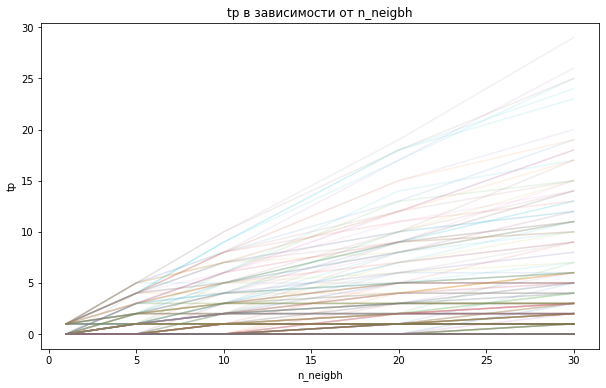

In [32]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["tp"], alpha=0.1)
plt.plot()
plt.title("tp в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("tp")
plt.show()

In [33]:
# средняя accuracy для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("n_neighb")["accuracy"].mean()

n_neighb
1     0.195719
5     0.165749
10    0.150459
20    0.129205
30    0.117125
Name: accuracy, dtype: float64

In [34]:
# средняя accuracy для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].groupby("n_neighb")["accuracy"].mean()

n_neighb
1     0.061111
5     0.033333
10    0.025556
20    0.020278
30    0.016667
Name: accuracy, dtype: float64

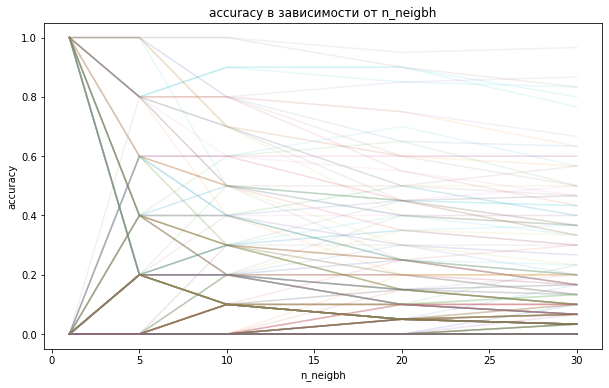

In [35]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["accuracy"], alpha=0.1)
plt.plot()
plt.title("accuracy в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("accuracy")
plt.show()

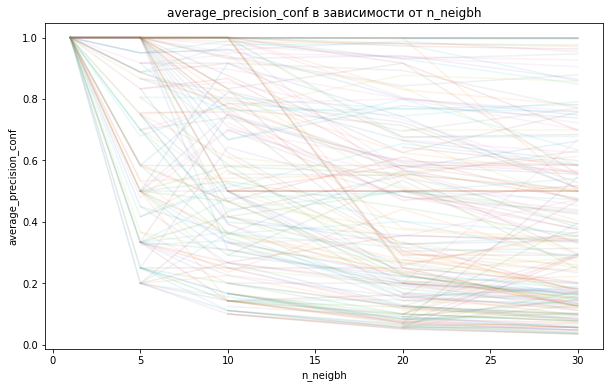

In [36]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["average_precision_conf"], alpha=0.1)
plt.plot()
plt.title("average_precision_conf в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("average_precision_conf")
plt.show()

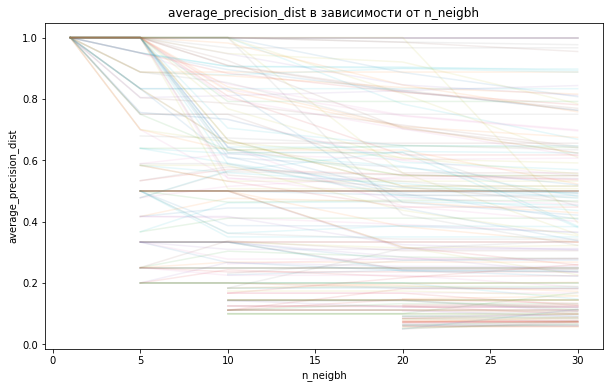

In [37]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["average_precision_dist"], alpha=0.1)
plt.plot()
plt.title("average_precision_dist в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("average_precision_dist")
plt.show()

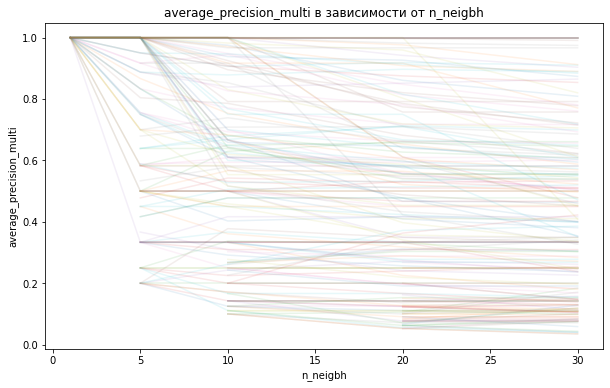

In [38]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["average_precision_multi"], alpha=0.1)
plt.plot()
plt.title("average_precision_multi в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("average_precision_multi")
plt.show()

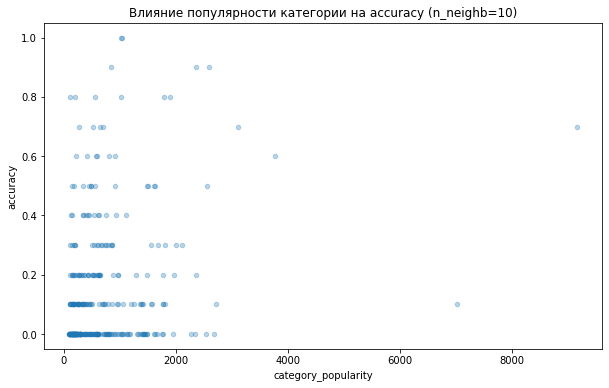

In [39]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)]
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .plot(
        "category_popularity",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на accuracy (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

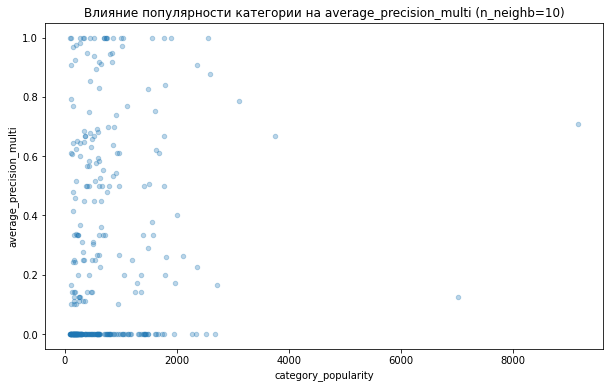

In [40]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)]
    .fillna(0)
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .plot(
        "category_popularity",
        "average_precision_multi",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на average_precision_multi (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

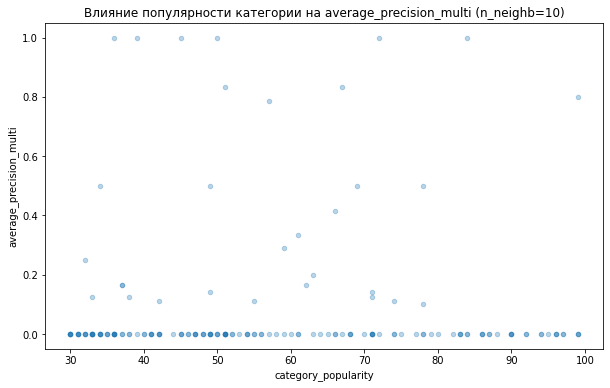

In [41]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)]
    .fillna(0)
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .plot(
        "category_popularity",
        "average_precision_multi",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на average_precision_multi (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

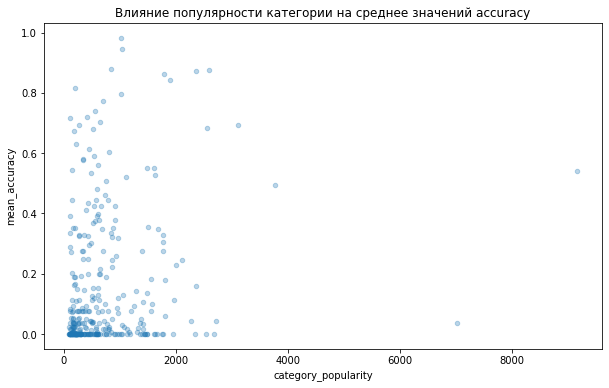

In [42]:
(
    metrics[metrics["category_id"].isin(ann[ann > 100].index)]
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .groupby(["category_id", "category_popularity"])["accuracy"]
    .mean()
    .reset_index(name="mean_accuracy")
    .plot(
        "category_popularity",
        "mean_accuracy",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на среднее значений accuracy",
        figsize=(10, 6),
    )
)
plt.show()

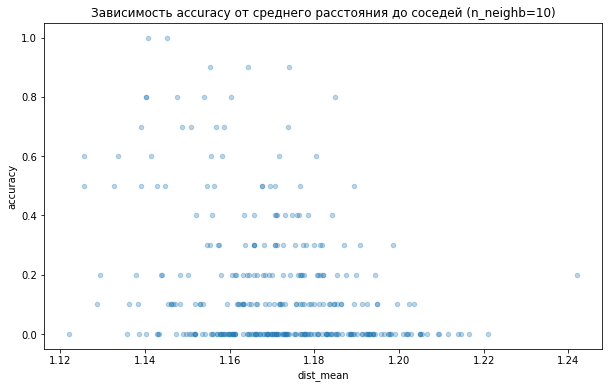

In [43]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].plot(
        "dist_mean",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Зависимость accuracy от среднего расстояния до соседей (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

In [44]:
# top категорий по минимальному расстоянию до соседей (что хорошо знает clip)
metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].sort_values("dist_mean").head(
    10
)

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,average_precision_multi,tp,dist_mean,conf_mean,iou_mean,accuracy
5097,1020,brake_light,10,NaN,NaN,NaN,0,1.122136,0.989725,NaN,0.0
4832,967,ski_pole,10,0.512063,0.460952,0.505397,5,1.125460,0.996054,0.880107,0.5
5392,1079,tennis_racket,10,0.896825,0.514815,0.693056,6,1.125524,0.987707,0.882724,0.6
4822,965,ski_boot,10,0.333333,0.142857,0.200000,1,1.128723,0.993434,0.891142,0.1
4997,1000,spoon,10,0.833333,0.583333,0.583333,2,1.129368,0.996345,0.938507,0.2
4877,976,snowboard,10,0.542222,0.839286,0.683333,5,1.132651,0.990925,0.762781,0.5
3487,698,monitor_(computer_equipment) computer_monitor,10,0.784259,0.620833,0.593849,6,1.133675,0.999240,0.924769,0.6
5887,1178,wheel,10,NaN,NaN,NaN,0,1.135740,0.992254,NaN,0.0
3132,627,lamppost,10,0.142857,0.111111,0.142857,1,1.136290,0.983194,0.520739,0.1
2342,469,fork,10,0.361111,0.333333,0.450000,2,1.137847,0.995117,0.694177,0.2


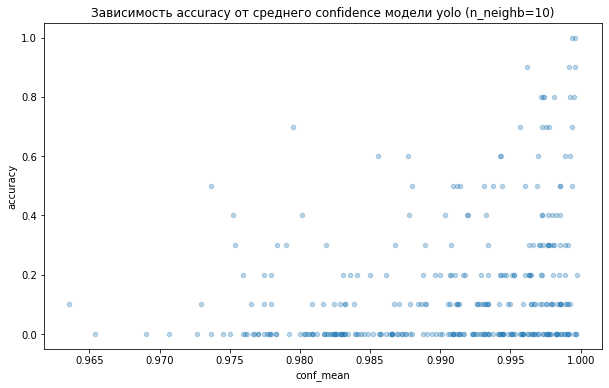

In [45]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].plot(
        "conf_mean",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Зависимость accuracy от среднего confidence модели yolo (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

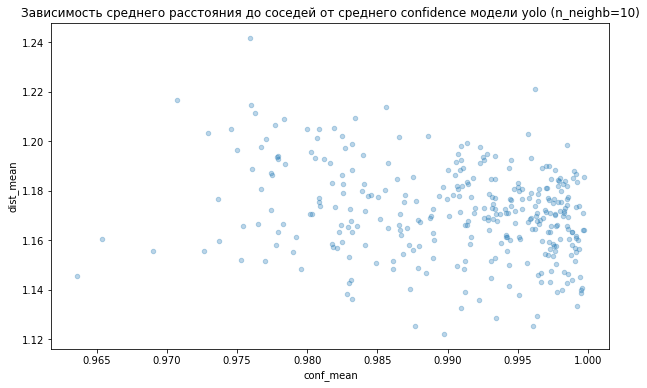

In [46]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].plot(
        "conf_mean",
        "dist_mean",
        kind="scatter",
        alpha=0.3,
        title="Зависимость среднего расстояния до соседей от среднего confidence модели yolo (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

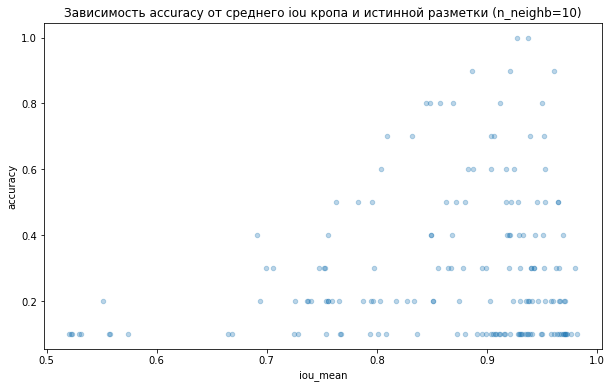

In [47]:
(
    metrics[
        (metrics["tp"] != 0) & (metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)
    ].plot(
        "iou_mean",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Зависимость accuracy от среднего iou кропа и истинной разметки (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()